In [56]:
import csv
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from lightgbm import LGBMClassifier

In [57]:
batch_size = 500000
split = 0.7

In [58]:
data = pd.read_csv('train_clean.csv')

In [59]:
data['batch'] = np.ceil((data['time'] * 10000) / batch_size)

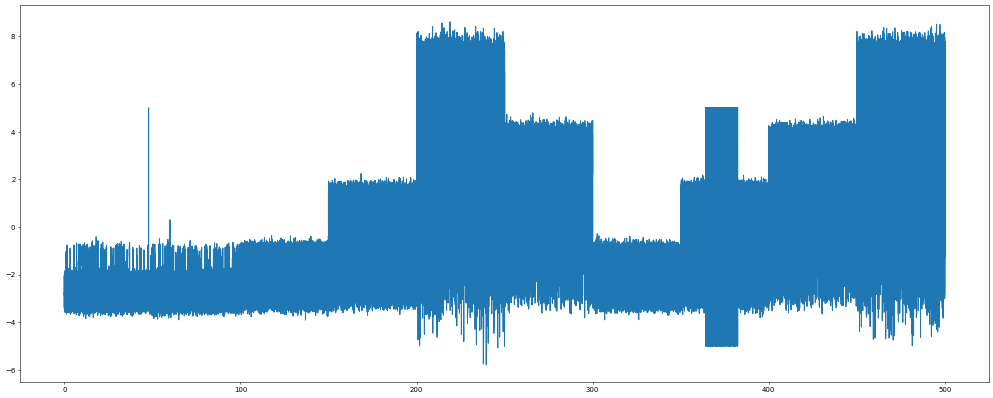

In [60]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(data['time'], data['signal'])

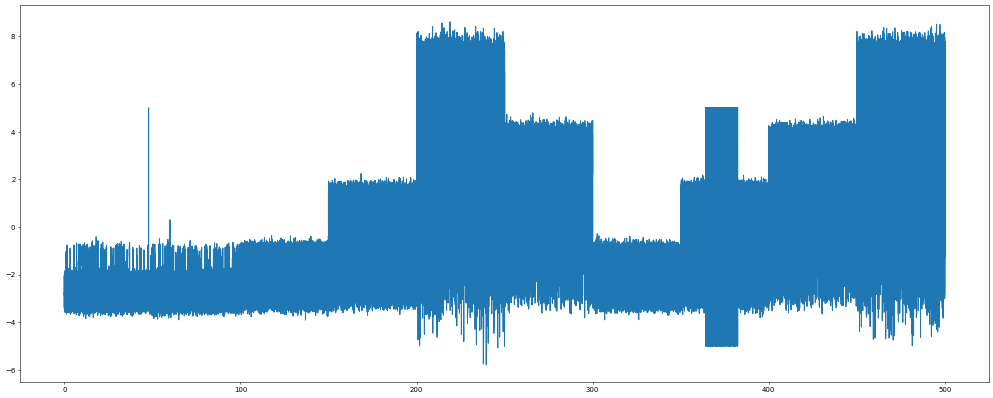

In [61]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(data['time'], data['signal'])

In [62]:
labels = np.array(data['open_channels'])

feature_cols = ['time','signal']
features= data[feature_cols]

feature_list = list(data.columns)
features = np.array(features)

In [63]:
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [64]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (3750000, 2)
Training Labels Shape: (3750000,)
Testing Features Shape: (1250000, 2)
Testing Labels Shape: (1250000,)


In [65]:
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)

In [66]:
model = OneVsRestClassifier(LGBMClassifier(max_depth=4))

In [67]:
model.fit(train_features, train_labels)

OneVsRestClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=4,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
                    

In [68]:
# Predicting the Test set results
predictions = model.predict(test_features)

In [69]:
# Making the Confusion Matrix
pd.crosstab(test_labels, predictions, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9,10
Actual,,,,,,,,,,,
0,308258,1397,88,8,0,1,0,1,0,0,0
1,1188,243809,1560,153,1,13,0,0,0,0,0
2,153,1611,134155,2568,7,76,0,0,0,0,0
3,80,181,3154,162384,1600,79,47,0,0,0,0
4,0,20,109,1565,96693,2219,179,39,0,0,0
5,0,0,53,341,1628,64418,2570,243,26,0,0
6,0,0,0,110,242,1836,40580,4340,0,0,0
7,0,0,0,0,87,7,3086,58382,4383,0,0
8,0,0,0,0,0,3,0,4273,53561,3609,0


In [70]:
accuracy_score(test_labels, predictions)

0.95992

In [71]:
f1_score(test_labels, predictions, average='macro')

0.9247425547810404

In [72]:
sub_data = pd.read_csv('test_clean.csv')
sub_data['batch'] = np.ceil((sub_data['time'] * 10000) / batch_size)

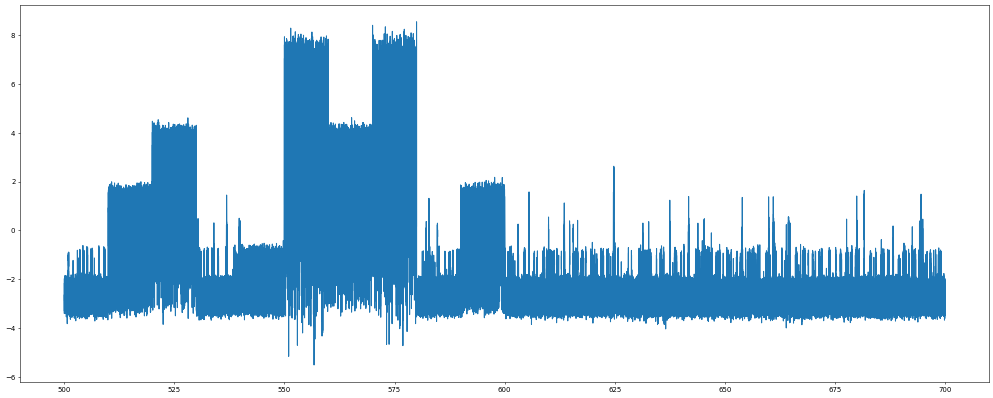

In [73]:
fig = plt.figure(figsize = (25, 10), dpi = 50, facecolor ='w', edgecolor ='k')
plt.plot(sub_data['time'], sub_data['signal'])

In [74]:
sub_data.head()

,time,signal,batch
0,500.0001,-2.649831,11.0
1,500.0002,-2.849463,11.0
2,500.0003,-2.860094,11.0
3,500.0004,-2.435126,11.0
4,500.0005,-2.615657,11.0


In [75]:
sub_features = sub_data[feature_cols]
sub_features = np.array(sub_features)
sub_features = sc.transform(sub_features)

In [76]:
sub_predictions = model.predict(sub_features)

In [77]:
sub_data['open_channels'] = sub_predictions

In [78]:
sub_data.sample(n=10, random_state=10)

,time,signal,batch,open_channels
690084,569.0085,2.548812,12.0,7
333871,533.3872,-2.214700,11.0,3
162719,516.2720,0.711499,11.0,5
1571186,657.1187,-2.693600,14.0,2
528149,552.8150,4.319500,12.0,8
505510,550.5511,3.882600,12.0,8
910611,591.0612,-0.250200,12.0,4
740722,574.0723,1.917263,12.0,6
1615440,661.5441,-2.745400,14.0,2
687279,568.7280,2.127203,12.0,6


In [79]:
out_cols = ['time', 'open_channels']
out_data = sub_data[out_cols]

In [80]:
out_data.to_csv('submission.csv', index=False, float_format='%.4f')